In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import GPy

In [3]:
%load_ext autoreload
%autoreload 2

In [82]:
from RECC import REC
from optim import Adam
from mix import genData

# generate some GP data

In [191]:
# generate training and testing data
np.random.seed(1234) 
X_train, X_test, Y_train, F_test, Y_test = genData(2000, D=1,lengthscale=[0.1], sig2_0=1.**2, sig2_noise=0.15**2)

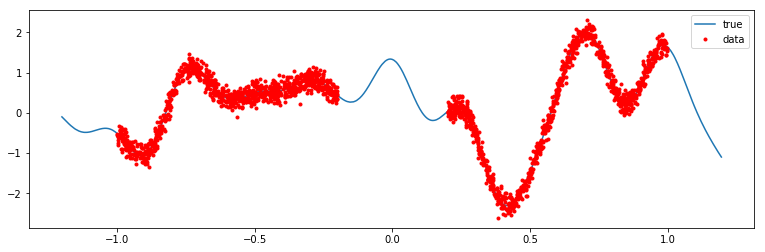

In [192]:
plt.figure(figsize=(13,4))
plt.plot(X_test, F_test, label='true');
plt.plot(X_train,Y_train, 'r.', label='data');
plt.legend();

# intitial values

In [193]:
# hyperparameters
sig_0_init = 1.
ls_init = [1.]
sig_noise_init = 1.0

# inducing inputs
M = 15
RR = np.linspace(-1,1,M)[:,None] 
α = 0.0001

# define kernel
kern = GPy.kern.RBF(input_dim = 1, variance=sig_0_init, lengthscale=ls_init, ARD=True) 

# batch sparse model with GPy

In [194]:
# define sparse mdoel
mod = GPy.models.SparseGPRegression(X_train, Y_train, kern.copy(), Z=RR.copy() )
# mod.inference_method = GPy.inference.latent_function_inference.VarDTC()
mod.inference_method = GPy.inference.latent_function_inference.PEP(α)
mod.Gaussian_noise = sig_0_init
mod.optimize(messages=False);

In [195]:
mod

sparse_gp.,value,constraints,priors
inducing inputs,"(15, 1)",,
rbf.variance,0.11882171302921597,+ve,
rbf.lengthscale,0.10134906617594445,+ve,
Gaussian_noise.variance,0.024697651577312213,+ve,


In [196]:
m1, v1 = mod.predict(X_test)

# recursive sparse model SRGP

In [237]:
sizeMiniBatch = 100
nEpochs = 100

In [253]:
# initial params
θ = {'σ0': sig_0_init, 'ls': np.ones(1)*ls_init, 'σn': sig_noise_init, 'R': RR.copy()}

# define optimizer for parameters
θopt_σ0 = Adam(0.01, (1,) ) 
θopt_σn = Adam(0.01, (1,) ) 
θopt_ls = Adam(0.01, (1,) ) 
θopt_R = Adam(0.001, RR.shape )   
θopt = {'σ0': θopt_σ0, 'ls': θopt_ls, 'σn': θopt_σn, 'R': θopt_R}

In [254]:
np.random.seed(123) # seed for permutation of the data
modSRGP = REC(X_train, Y_train, kern.copy(), nEpochs, sizeMiniBatch, θ, θopt, α=α, 
           Xtest=X_test, Ftest=F_test[:,0], Ytest=Y_test[:,0] ) # only for performance testing

modSRGP.run()

epoch:  99
log marginal likelihood:  728.9087511820175
RMSE  0.40651387758303464  negLogP  0.25997573760578463  COV  0.898
σ20:  [0.12000806]  ls:  [0.10203801]  σ2n:  [0.02427091]


In [255]:
m2, v2 = modSRGP.predict_diag(X_test)

# comparison between batch and SRGP

## mean

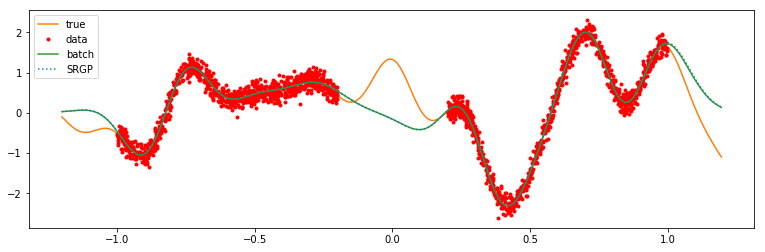

In [256]:
plt.figure(figsize=(13,4))
plt.plot(X_test, F_test, 'C1', label='true');
plt.plot(X_train,Y_train, 'r.', label='data');

plt.plot(X_test, m1, 'C2', label='batch')
plt.plot(X_test, m2, 'C0:', label='SRGP')

plt.legend();

## variance

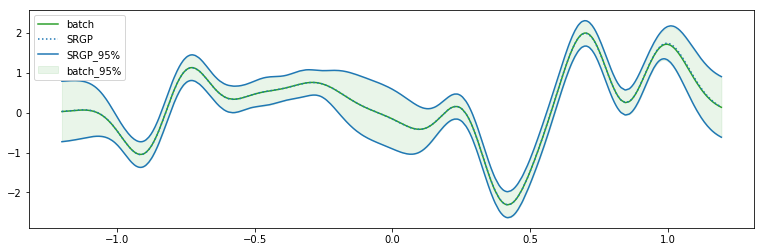

In [257]:
plt.figure(figsize=(13,4))

plt.plot(X_test, m1, 'C2', label='batch')
plt.plot(X_test, m2, 'C0:', label='SRGP')

plt.fill_between(X_test[:,0],m1[:,0]-2*np.sqrt(v1[:,0]),\
                      m1[:,0]+2*np.sqrt(v1[:,0]), alpha=0.1, color='C2', label='batch_95%')

plt.plot(X_test[:,0], m2-2*np.sqrt(v2), 'C0', label='SRGP_95%')
plt.plot(X_test[:,0], m2+2*np.sqrt(v2), 'C0')

plt.legend();

## inducing points

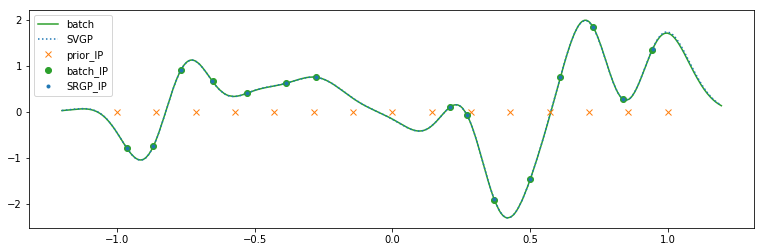

In [258]:
plt.figure(figsize=(13,4))

plt.plot(X_test, m1, 'C2', label='batch')
plt.plot(X_test, m2, 'C0:', label='SVGP')

plt.plot(RR, np.zeros((M,1)), 'C1x', label='prior_IP')
plt.plot(mod.inducing_inputs, mod.posterior.mean, 'C2o', label='batch_IP')
plt.plot(modSRGP.params['R'], modSRGP.m[:,None], 'C0.', label='SRGP_IP')

plt.legend();

## convergence of RMSE and bound

In [259]:
xL = np.arange(nEpochs)
rmseBatch = np.mean( (F_test[:,0]-m1[:,0])**2)**(0.5)

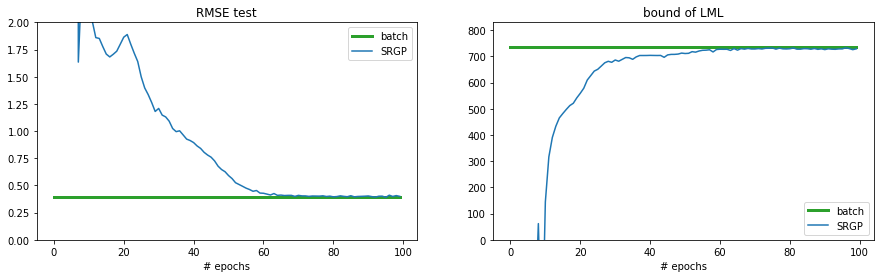

In [260]:
f, axs = plt.subplots(1, 2, sharex=True, figsize=(15,4))
ax1 = axs[0]
ax2 = axs[1]
# ax3 = axs[2]

ax1.plot( xL, rmseBatch*np.ones(nEpochs)  , 'C2', lw=3, label='batch' );
ax1.plot( xL, modSRGP.STATS[1,:], 'C0', label='SRGP' );
ax1.set_ylim(0.,2);
ax1.legend()
ax1.set_title('RMSE test')
ax1.set_xlabel('# epochs')

ax2.plot( xL, mod._log_marginal_likelihood[0]*np.ones(nEpochs)  , 'C2',  lw=3,label='batch' );
ax2.plot( xL, modSRGP.STATS[0,:] , 'C0', label='SRGP' );
ax2.set_ylim(0,830);
ax2.set_title('bound of LML')
ax2.legend();
ax2.set_xlabel('# epochs');

## convergence of hyperparameters

In [261]:
xOne = np.ones(nEpochs+1)
xL2 = np.arange(nEpochs+1)

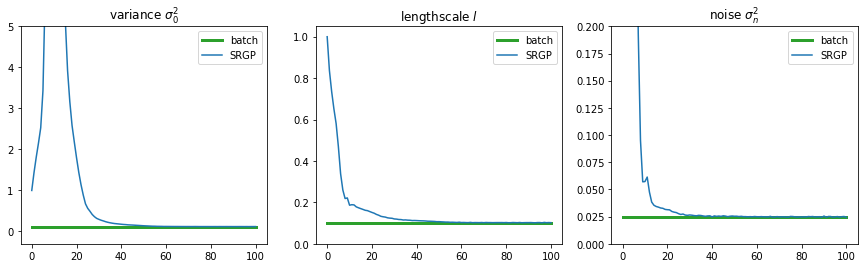

In [262]:
f, axs = plt.subplots(1, 3, sharex=True, figsize=(15,4))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

# simga2_0
ax1.plot( xL2, mod.rbf.variance*xOne  , 'C2', lw=3, label='batch' );
ax1.plot( xL2, np.hstack([sig_0_init, modSRGP.STATS_Y[0,:] ])**2 , 'C0', label='SRGP' );
ax1.set_ylim(-0.3, 5);
ax1.set_title('variance '+r'$\sigma_0^2$')
ax1.legend();

# lengthscale
ax2.plot( xL2, mod.rbf.lengthscale[0]*xOne  , 'C2', lw=3, label='batch' );
ax2.plot( xL2, np.hstack([ls_init, modSRGP.STATS_Y[1,:] ]) , 'C0', label='SRGP' );
ax2.set_ylim(0., 1.05);
ax2.set_title('lengthscale '+r'$l$')
ax2.legend();

# lengthscale
ax3.plot( xL2, mod.Gaussian_noise.variance[0]*xOne  , 'C2', lw=3, label='batch' );
ax3.plot( xL2, np.hstack([sig_noise_init, modSRGP.STATS_Y[2,:] ])**2 , 'C0', label='SRGP' );
ax3.set_ylim(0., .2);
ax3.set_title('noise '+r'$\sigma_n^2$')
ax3.legend();